### Задача 1
Поддерживать и стимулировать пользовательскую активность – важная задача для продукта, подобного нашему. Для этого наша команда маркетологов решила организовать флэшмоб в ленте новостей: участники должны сделать пост, где они рассказывают какой-то интересный факт о себе, и опубликовать его с хэштегом. Три поста, собравших наибольшее число лайков, получают призы.

Флэшмоб проходил с 2023-08-13 по 2023-08-19. Ваша задача как аналитика – оценить эффективность этого мероприятия.

Предположите, какие метрики должны были измениться во время флэшмоба и как. Почему?
Проверьте, реально ли эти метрики изменились, используя CausalImpact. Если изменение действительно произошло - опишите, как именно изменилась метрика и насколько.
Имел ли флэшмоб какие-то долгосрочные эффекты? Сделайте выводы.
Формат сдачи задания – merge request в GitLab с ноутбуком, где выполнены вычисления (формат .ipynb).

In [4]:
import pandas as pd
import seaborn as sns
import pandahouse
from causalimpact import CausalImpact

In [53]:
#читаем нашу бд

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

q = """
SELECT toDate(time) as time, 
        count(distinct user_id) as dau,
        countIf(post_id, action = 'view') as views,  
        countIf(post_id, action = 'like') as likes, 
        likes/views as ctr
FROM simulator_20230820.feed_actions
WHERE toDate(time) between '2023-08-02' and '2023-09-18'
GROUP BY time
ORDER BY time
"""

df = pandahouse.read_clickhouse(q, connection=connection)

#дф который мы выгрузили
df.head()

,time,dau,views,likes,ctr
0,2023-08-02,13928,458803,97688,0.212919
1,2023-08-03,14540,549607,114920,0.209095
2,2023-08-04,14774,581472,120932,0.207976
3,2023-08-05,14276,583554,126519,0.216808
4,2023-08-06,13996,493534,109499,0.221867


In [7]:
df.columns

Index(['htime', 'dau', 'views', 'likes', 'ctr'], dtype='object')

Какие метрики должны измениться благодаря флешмобу?
Флешмоб должен стимулировать количество лайков (об этом прямо указано в цели), соотвественно просмотры тоже вырастут.
Не совсем понятно, как это повлияет на DAU - привлечет ли флешмоб новых пользователей?

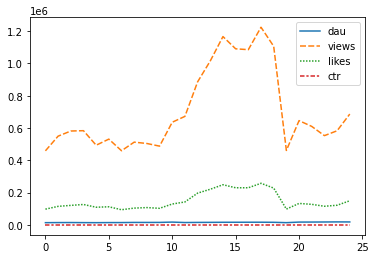

In [18]:
# лайки и просмотры выросли (флешмоб начинается со 2й недели в наших данных)
_ = sns.lineplot(data = df)

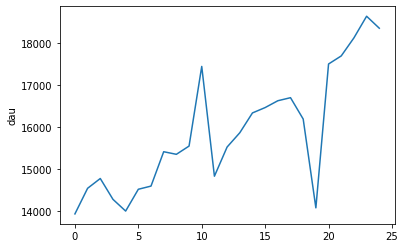

In [28]:
# анализ DAU Попробуем анализировать его!
_ = sns.lineplot(data=df.dau)

In [29]:
df1 = df[['time', 'dau']][df.time < '2023-08-20'].set_index('time')
df1

,dau
time,
2023-08-02,13928
2023-08-03,14540
2023-08-04,14774
2023-08-05,14276
2023-08-06,13996
2023-08-07,14517
2023-08-08,14593
2023-08-09,15414
2023-08-10,15352


In [31]:
impact_dau = CausalImpact(data = df1.dau, 
                      pre_period = ['2023-08-02', '2023-08-12'], #период до события
                      post_period = ['2023-08-13', '2023-08-19'], #период после события
                      ) 

2023-09-20 09:17:17.936969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-09-20 09:17:17.966419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-09-20 09:17:18.642328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-09-20 09:

2023-09-20 09:17:35.332292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1' with dtype int32 and shape [2]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1}}]]
2023-09-20 09:17:35.432458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/whil

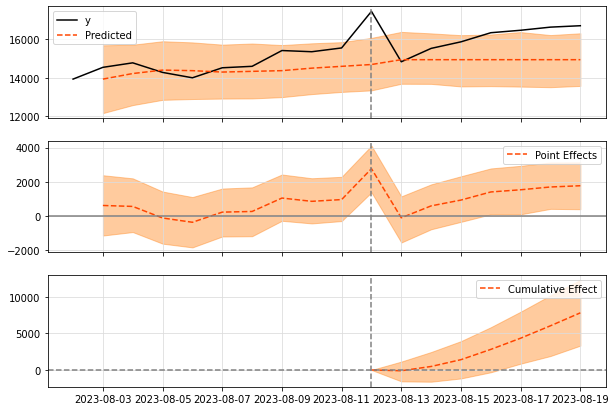

In [32]:
impact_dau.plot()

In [33]:
# как мы видим, рост CTR составил 7.46%
print(impact_dau.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    16052.71           112369.0
Prediction (s.d.)         14938.12 (318.73)  104566.83 (2231.14)
95% CI                    [14309.49, 15558.91][100166.45, 108912.35]

Absolute effect (s.d.)    1114.6 (318.73)    7802.17 (2231.14)
95% CI                    [493.81, 1743.22]  [3456.65, 12202.55]

Relative effect (s.d.)    7.46% (2.13%)      7.46% (2.13%)
95% CI                    [3.31%, 11.67%]    [3.31%, 11.67%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 99.9%

For more details run the command: print(impact.summary('report'))


In [34]:
# попробуем отчет
print(impact_dau.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 16052.71. By contrast, in the absence of an
intervention, we would have expected an average response of 14938.12.
The 95% interval of this counterfactual prediction is [14309.49, 15558.91].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 1114.6 with a 95% interval of
[493.81, 1743.22]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 112369.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 104566.83. The 95% interval of this prediction is [100166.45, 108912.35].


The above results are given in terms of absolute numbers. In relative

In [61]:
# проверим CausalImpact на лайках
df2 = df[['time', 'likes']].set_index('time')
impact_likes = CausalImpact(data = df2, 
                      pre_period = ['2023-08-02', '2023-08-12'], #период до события
                      post_period = ['2023-08-13', '2023-08-19'], #период после события
                      ) 

2023-09-20 10:51:30.932170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-09-20 10:51:30.960656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-09-20 10:51:31.644412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-09-20 10:

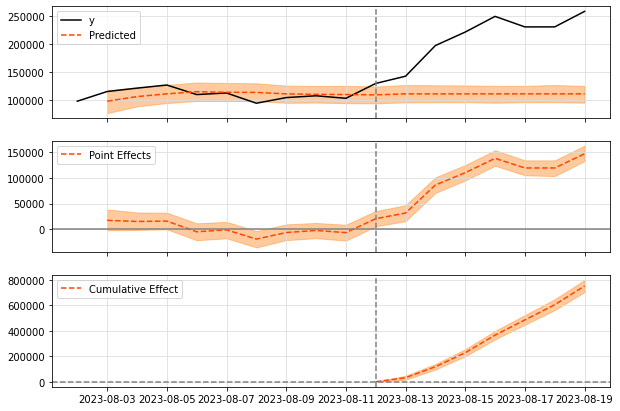

In [40]:
impact_likes.plot()

In [42]:
print(impact_likes.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    218090.14          1526631.0
Prediction (s.d.)         110756.42 (3672.87)775294.94 (25710.11)
95% CI                    [103212.15, 117609.55][722485.05, 823266.87]

Absolute effect (s.d.)    107333.72 (3672.87)751336.06 (25710.11)
95% CI                    [100480.59, 114877.99][703364.13, 804145.95]

Relative effect (s.d.)    96.91% (3.32%)     96.91% (3.32%)
95% CI                    [90.72%, 103.72%]  [90.72%, 103.72%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [45]:
# проверим CausalImpact на просмотрах
df3 = df[['time', 'views']][df.time < '2023-08-20'].set_index('time')
impact_views = CausalImpact(data = df3, 
                      pre_period = ['2023-08-02', '2023-08-12'], #период до события
                      post_period = ['2023-08-13', '2023-08-19'], #период после события
                      ) 

2023-09-20 10:32:55.804871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-09-20 10:32:55.833750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-09-20 10:32:56.513603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-09-20 10:

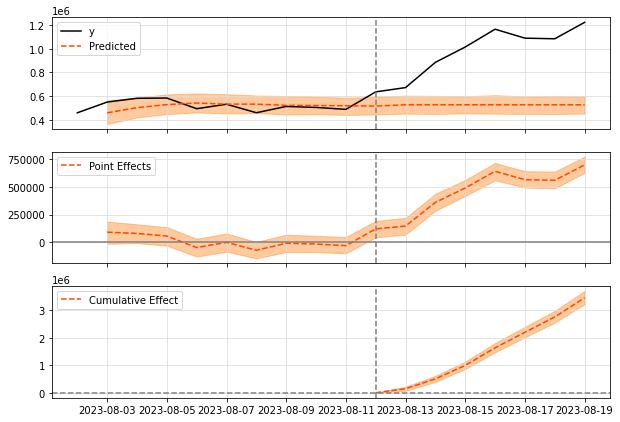

In [46]:
impact_views.plot()

In [48]:
print(impact_views.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    1019947.31         7139631.0
Prediction (s.d.)         526603.44 (18428.16)3686224.25 (128997.06)
95% CI                    [489546.8, 561783.87][3426827.69, 3932486.98]

Absolute effect (s.d.)    493343.88 (18428.16)3453406.75 (128997.06)
95% CI                    [458163.44, 530400.51][3207144.02, 3712803.31]

Relative effect (s.d.)    93.68% (3.5%)      93.68% (3.5%)
95% CI                    [87.0%, 100.72%]   [87.0%, 100.72%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


### Вывод
1. Мы проанализировали три метрики: лайки, просмотры и активных пользователей и их динамику за неделю до и после флешмоба.
2. Активные пользователи - рост 7.46% 
3. Лайки - 96.91%
4. Просмотры - 93.68%
